In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from PIL import Image
import random

# Detekcja Azbestu na Budynkach

Ten notebook zawiera pełny pipeline do detekcji azbestu na zdjęciach budynków przy użyciu głębokiej sieci neuronowej z blokami Inception.

## 1. Ładowanie danych

In [38]:
# dane z pliku CSV; filename, has_asbestos
csv_path = Path('./building_labels_merged.csv')
df = pd.read_csv(csv_path)

images_dir = Path('./building_images_merged')
images = []

for idx, row in df.iterrows():
    img_path = images_dir / row['filename']
    if img_path.exists():
        img = Image.open(img_path).convert('RGB')
        images.append(transforms.ToTensor()(img))

images = torch.stack(images)
labels = torch.as_tensor(df['has_asbestos'].values, dtype=torch.long)

print(f"Załadowano {len(images)} obrazów")
print(f"Kształt obrazów: {images.shape}")
print(f"Rozkład klas - Bez azbestu: {(labels==0).sum().item()}, Z azbestem: {(labels==1).sum().item()}")

Załadowano 1263 obrazów
Kształt obrazów: torch.Size([1263, 3, 128, 128])
Rozkład klas - Bez azbestu: 682, Z azbestem: 581


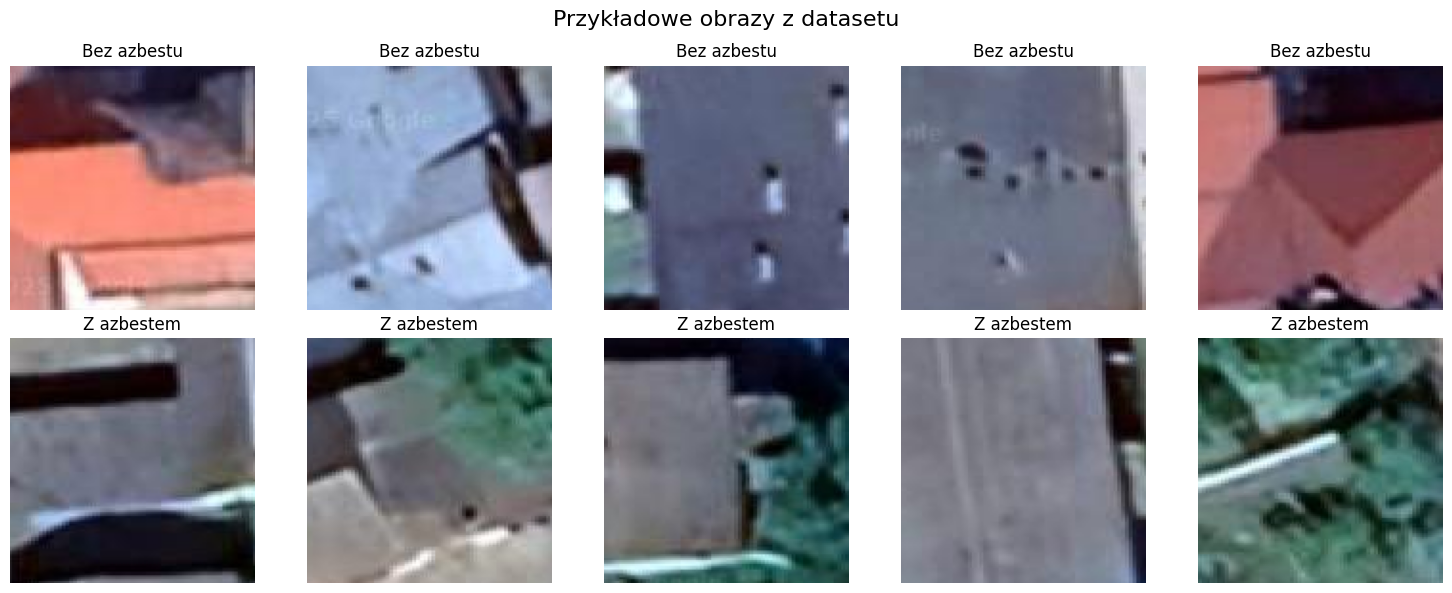

In [39]:
# Wizualizacja przykładowych obrazów
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Przykładowe obrazy z datasetu', fontsize=16)

# Bez azbestu
normal_indices = (labels == 0).nonzero(as_tuple=True)[0]
for i, ax in enumerate(axes[0]):
    idx = normal_indices[i].item()
    # Konwersja z (C, H, W) do (H, W, C) dla matplotlib
    img_display = images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img_display)
    ax.set_title('Bez azbestu')
    ax.axis('off')

# Z azbestem
azbest_indices = (labels == 1).nonzero(as_tuple=True)[0]
for i, ax in enumerate(axes[1]):
    idx = azbest_indices[i].item()
    img_display = images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img_display)
    ax.set_title('Z azbestem')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
# Analiza statystyk RGB
normal_indices = (labels == 0).nonzero(as_tuple=True)[0]
azbest_indices = (labels == 1).nonzero(as_tuple=True)[0]

normal_images = images[normal_indices]  # Shape: (N_normal, C, H, W)
azbest_images = images[azbest_indices]  # Shape: (N_azbest, C, H, W)

# Średnie wartości dla każdego kanału
normal_mean = normal_images.mean(dim=(0, 2, 3))  # Średnia po: batch, height, width
azbest_mean = azbest_images.mean(dim=(0, 2, 3))

# Odchylenie standardowe dla każdego kanału
normal_std = normal_images.std(dim=(0, 2, 3))
azbest_std = azbest_images.std(dim=(0, 2, 3))

print("Średnie wartości pikseli (RGB, znormalizowane [0,1]):")
print(f"  Bez azbestu: R={normal_mean[0]:.3f}, G={normal_mean[1]:.3f}, B={normal_mean[2]:.3f}")
print(f"  Z azbestem:  R={azbest_mean[0]:.3f}, G={azbest_mean[1]:.3f}, B={azbest_mean[2]:.3f}")
print("\nOdchylenie standardowe (RGB):")
print(f"  Bez azbestu: R={normal_std[0]:.3f}, G={normal_std[1]:.3f}, B={normal_std[2]:.3f}")
print(f"  Z azbestem:  R={azbest_std[0]:.3f}, G={azbest_std[1]:.3f}, B={azbest_std[2]:.3f}")

Średnie wartości pikseli (RGB, znormalizowane [0,1]):
  Bez azbestu: R=0.373, G=0.345, B=0.382
  Z azbestem:  R=0.345, G=0.355, B=0.397

Odchylenie standardowe (RGB):
  Bez azbestu: R=0.251, G=0.235, B=0.233
  Z azbestem:  R=0.224, G=0.227, B=0.220


In [41]:
import plotly.graph_objs as go
from IPython.display import display, clear_output
import numpy as np
from PIL import Image
import torch 

try:
    if 'images' not in globals() or 'labels' not in globals():
        raise RuntimeError('Brak wymaganych tensorów `images` lub `labels` w przestrzeni roboczej. Uruchom najpierw komórki ładowania i przygotowania danych.')

    # 1. Obliczanie współrzędnych (średnia RGB)
    rgb_means = images.mean(dim=(2, 3)).cpu().numpy()
    
    # 2. Przygotowanie danych klasyfikacyjnych dla koloryzacji i symboli
    class_labels = labels.cpu().numpy()
    
    # Ustalenie symboli: 0 (Bez azbestu) = circle, 1 (Z azbestem) = diamond
    symbols = np.where(class_labels == 1, 'diamond', 'circle').tolist()
    
    label_names = np.array(['Bez azbestu (0)', 'Z azbestem (1)'])
    
    # Tworzenie opisowego tekstu po najechaniu myszką
    hover_text = [f"Klasa: {label_names[y]}<br>R: {r:.3f}, G: {g:.3f}, B: {b:.3f}<br>idx={i}"
                  for i, (y, r, g, b) in enumerate(zip(class_labels, rgb_means[:, 0], rgb_means[:, 1], rgb_means[:, 2]))]

    # 3. Tworzenie jednego śladu
    single_trace = go.Scatter3d(
        x=rgb_means[:, 0],
        y=rgb_means[:, 1],
        z=rgb_means[:, 2],
        mode='markers',
        # Użycie etykiet klas dla koloru i tablicy symboli
        marker=dict(
            size=7,
            color=class_labels,
            # Dostosowana skala: 0=niebieski, 1=czerwony
            colorscale=[[0, 'blue'], [1, 'red']], 
            colorbar=dict(
                tickvals=[0, 1],
                ticktext=label_names.tolist(),
                title='Klasyfikacja'
            ),
            symbol=symbols,
            cmin=0,
            cmax=1,
            line=dict(width=0.2, color='black')
        ),
        name='Dane RGB',
        text=hover_text,
        hoverinfo='text',
        customdata=np.arange(len(rgb_means)).tolist(), # Lista indeksów
        showlegend=True,
    )

    scatter = go.FigureWidget(data=[single_trace])

    scatter.update_layout(
        title='Interaktywny rozrzut RGB - Symbole i kolory wg klasy (wybierz, aby zobaczyć)',
        scene=dict(xaxis_title='R (średnia)', yaxis_title='G (średnia)', zaxis_title='B (średnia)'),
        height=650,
    )

    display(scatter)

    # 4. Funkcja obsługująca interakcję (poprawne pobieranie customdata)
    def _show_selected(trace, points, selector):
        clear_output(wait=True)
        display(scatter)
        
        if points.point_inds is None:
            print('Brak wybranych punktów — użyj zaznaczania prostokątem lub lasso, aby wybrać obrazy.')
            return

        # Używamy points.point_inds do indeksowania listy customdata, aby uzyskać oryginalne ID obrazów
        selected_data = np.array(trace.customdata)
        sel = selected_data[points.point_inds].tolist()

        if len(sel) == 0:
            print('Brak wybranych punktów — użyj zaznaczania prostokątem lub lasso, aby wybrać obrazy.')
            return

        print(f'Wybrano {len(sel)} indeksów: {sel}')
        for idx in sel:
            current_label = label_names[labels[int(idx)].item()]
            
            img_t = images[int(idx)].permute(1, 2, 0).cpu().numpy()
            if img_t.max() <= 1.0:
                img_out = (img_t * 255).astype('uint8')
            else:
                img_out = img_t.astype('uint8')
            im = Image.fromarray(img_out)
            display(f'Index {idx} ({current_label})', im)

    # Dołączenie handlera do jedynego śladu
    scatter.data[0].on_selection(_show_selected)

except Exception as exc:
    import traceback
    traceback.print_exc()
    print('Nie udało się utworzyć interaktywnego rozrzutu RGB (upewnij się, że masz zainstalowane anywidget):', exc)

FigureWidget({
    'data': [{'customdata': [0, 1, 2, ..., 1260, 1261, 1262],
              'hoverinfo': 'text',
              'marker': {'cmax': 1,
                         'cmin': 0,
                         'color': {'bdata': ('AAAAAAAAAAABAAABAQABAQAAAAABAA' ... 'EAAQABAQABAQEBAAEAAAEBAAABAQAB'),
                                   'dtype': 'i1'},
                         'colorbar': {'ticktext': [Bez azbestu (0), Z azbestem
                                                   (1)],
                                      'tickvals': [0, 1],
                                      'title': {'text': 'Klasyfikacja'}},
                         'colorscale': [[0, 'blue'], [1, 'red']],
                         'line': {'color': 'black', 'width': 0.2},
                         'size': 7,
                         'symbol': [circle, circle, circle, ..., diamond, circle,
                                    diamond]},
              'mode': 'markers',
              'name': 'Dane RGB',
              '

# 2. Konfiguracja eksperymentu i przygotowanie danych

In [42]:
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Urządzenie:', device)

# Podział na zbiory: najpierw dzielimy (bez normalizacji), aby globalne mean/std obliczyć tylko z treningowego zbioru
X_train, X_tmp, y_train, y_tmp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

print('Rozmiary zbiorów:', len(X_train), len(X_val), len(X_test))

# Obliczamy globalne mean/std tylko na zbiorze treningowym
global_mean = X_train.mean(dim=(0, 2, 3))
global_std = X_train.std(dim=(0, 2, 3)).clamp_min(1e-6)
print('Globalne srednie (z train):', [round(x.item(), 6) for x in global_mean])
print('Globalne std (z train):', [round(x.item(), 6) for x in global_std])

# Normalizacja obrazów przy użyciu mean/std obliczonych z treningu
X_train = (X_train - global_mean[None, :, None, None]) / global_std[None, :, None, None]
X_val   = (X_val   - global_mean[None, :, None, None]) / global_std[None, :, None, None]
X_test  = (X_test  - global_mean[None, :, None, None]) / global_std[None, :, None, None]

from torch.utils.data import TensorDataset
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)


Urządzenie: mps
Rozmiary zbiorów: 884 189 190
Globalne srednie (z train): [0.361592, 0.349724, 0.388167]
Globalne std (z train): [0.240603, 0.23154, 0.227588]


# 3. Architektura sieci – bloki ekstrakcji cech (Inception‑like)

In [43]:
class InceptionBlock(nn.Module):
    """Blok ekstrakcji cech zgodny ze schematem (3 równoległe gałęzie):
    - Gałąź 1: 1x1 (32f) -> ReLU -> 3x3 (64f) -> ReLU -> BN
    - Gałąź 2: 1x1 (32f) -> ReLU -> 5x5 (64f) -> ReLU -> BN
    - Gałąź 3: MaxPool 3x3 -> 5x5 (64f) -> ReLU -> BN
    Wyjście: konkatenacja [64, 64, 64] = 192 kanałów.
    """
    def __init__(self, in_channels: int):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.branch3_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch3_post = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )

    @property
    def out_channels(self) -> int:
        return 64 * 3

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3_post(self.branch3_pool(x))
        return torch.cat([b1, b2, b3], dim=1)


# 4. Pełna architektura sieci (AsbestosNet)

In [ ]:
class AsbestosNet(nn.Module):
    def __init__(self, input_shape, num_classes: int = 2, p_spatial: float = 0.55, p_dense: float = 0.5):
        super().__init__()
        c, h, w = input_shape
        self.stem = nn.Sequential(
            nn.Conv2d(c, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        
        self.block1 = InceptionBlock(64)
        self.block2 = InceptionBlock(self.block1.out_channels)
        self.block3 = InceptionBlock(self.block2.out_channels)

        self.pool_stride2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.pool_last = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.spatial_dropout = nn.Dropout2d(p=p_spatial)

        # Wyznaczenie rozmiaru cech po konwolucjach dynamicznie
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.stem(x)
            x = self.pool_stride2(self.spatial_dropout(self.block1(x)))
            x = self.pool_stride2(self.spatial_dropout(self.block2(x)))
            x = self.pool_stride2(self.spatial_dropout(self.block3(x)))
            x = self.spatial_dropout(self.pool_last(x))
            flat_dim = x.numel()
        self.flatten_dim = flat_dim

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p_dense),
            nn.Linear(1024, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p_dense),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.pool_stride2(self.spatial_dropout(self.block1(x)))
        x = self.pool_stride2(self.spatial_dropout(self.block2(x)))
        x = self.pool_stride2(self.spatial_dropout(self.block3(x)))
        x = self.spatial_dropout(self.pool_last(x))
        x = self.fc(x)
        return x

# Szybka weryfikacja kształtów
input_shape = tuple(images.shape[1:])  # (C, H, W)
model = AsbestosNet(input_shape).to(device)
print(model.__class__.__name__, '– liczba parametrów:', sum(p.numel() for p in model.parameters()))


AsbestosNet – liczba parametrów: 52343746


# 5. Trening – pętla ucząca z EarlyStopping

In [45]:
from collections import defaultdict

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    all_preds, all_targets = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        all_preds.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
        all_targets.extend(y.detach().cpu().tolist())
    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(all_targets, all_preds)
    return avg_loss, metrics

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            all_preds.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
            all_targets.extend(y.detach().cpu().tolist())
    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(all_targets, all_preds)
    return avg_loss, metrics

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1)

# Hiperparametry
epochs = 128
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping
best_val_loss = float('inf')
patience = 10
patience_left = patience
best_state = None
history = defaultdict(list)

for epoch in range(1, epochs + 1):
    train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_metrics = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    for k, v in train_metrics.items():
        history[f'train_{k}'].append(v)
    for k, v in val_metrics.items():
        history[f'val_{k}'].append(v)

    print(f"Epoka {epoch:02d} | train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_metrics['accuracy']:.3f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left == 0:
            print('Wcześniejsze zatrzymanie (early stopping).')
            break

# Przywrócenie najlepszego stanu
if best_state is not None:
    model.load_state_dict(best_state)


Epoka 01 | train_loss=0.8817, val_loss=1.3693, val_acc=0.540
Epoka 02 | train_loss=0.7109, val_loss=0.6407, val_acc=0.688
Epoka 02 | train_loss=0.7109, val_loss=0.6407, val_acc=0.688
Epoka 03 | train_loss=0.6164, val_loss=0.6022, val_acc=0.720
Epoka 03 | train_loss=0.6164, val_loss=0.6022, val_acc=0.720
Epoka 04 | train_loss=0.5672, val_loss=0.5567, val_acc=0.735
Epoka 04 | train_loss=0.5672, val_loss=0.5567, val_acc=0.735
Epoka 05 | train_loss=0.5933, val_loss=0.6592, val_acc=0.672
Epoka 05 | train_loss=0.5933, val_loss=0.6592, val_acc=0.672
Epoka 06 | train_loss=0.5749, val_loss=0.5461, val_acc=0.746
Epoka 06 | train_loss=0.5749, val_loss=0.5461, val_acc=0.746
Epoka 07 | train_loss=0.5461, val_loss=0.5526, val_acc=0.735
Epoka 07 | train_loss=0.5461, val_loss=0.5526, val_acc=0.735
Epoka 08 | train_loss=0.5344, val_loss=0.5471, val_acc=0.741
Epoka 08 | train_loss=0.5344, val_loss=0.5471, val_acc=0.741
Epoka 09 | train_loss=0.5266, val_loss=0.5636, val_acc=0.757
Epoka 09 | train_loss=0.

# 6. Ewaluacja na zbiorze testowym i wizualizacje

Walidacja – {'accuracy': 0.798941798941799, 'precision': 0.7752808988764045, 'recall': 0.7931034482758621, 'f1': 0.7840909090909091}
Test – {'accuracy': 0.8210526315789474, 'precision': 0.7849462365591398, 'recall': 0.8390804597701149, 'f1': 0.8111111111111111}
Test – {'accuracy': 0.8210526315789474, 'precision': 0.7849462365591398, 'recall': 0.8390804597701149, 'f1': 0.8111111111111111}


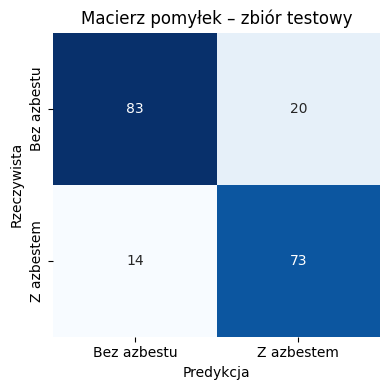

In [50]:
val_loss, val_metrics = evaluate(model, val_loader, criterion)
print('Walidacja –', val_metrics)

test_loss, test_metrics = evaluate(model, test_loader, criterion)
print('Test –', test_metrics)

# Macierz pomyłek
all_preds, all_targets = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_targets.extend(y.tolist())
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bez azbestu', 'Z azbestem'],
            yticklabels=['Bez azbestu', 'Z azbestem'])
plt.title('Macierz pomyłek – zbiór testowy')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.tight_layout()
plt.show()


# 7. Zapis modelu i konfiguracji

In [51]:
ckpt = {
    'state_dict': model.state_dict(),
    'input_shape': input_shape,
    'mean': global_mean,
    'std': global_std,
    'history': dict(history),
}
Path('./artifacts').mkdir(exist_ok=True)
ckpt_path = Path('./artifacts/asbestos_net.pt')
torch.save(ckpt, ckpt_path)
print('Zapisano model do', ckpt_path)


Zapisano model do artifacts/asbestos_net.pt


Najlepszy próg: 0.43  —  F1: 0.7845
Precision, Recall, F1: 0.7553191489361702 0.8160919540229885 0.7845303867403315
Confusion matrix:
 [[79 23]
 [16 71]]


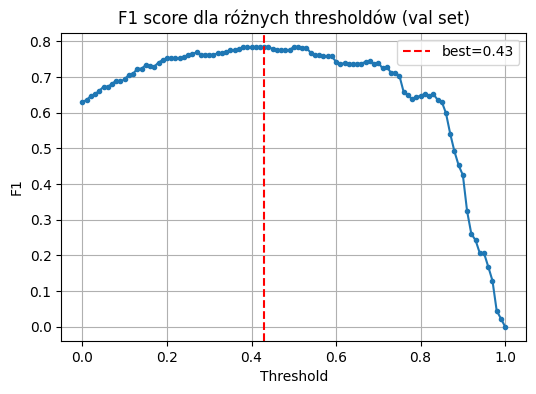

In [61]:
# Komórka: znajdowanie najlepszego threshold
def find_best_threshold(model, loader, device=device, step=0.01):
    import numpy as np
    from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
    model.eval()
    probs_list = []
    targets_list = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            if logits.ndim == 2 and logits.size(1) > 1:
                pos = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            else:
                pos = torch.sigmoid(logits.view(-1)).cpu().numpy()
            probs_list.append(pos)
            targets_list.append(y.cpu().numpy())
    if len(probs_list) == 0:
        raise RuntimeError('Val loader zwrócił 0 batchy — upewnij się, że `val_loader` zawiera dane.')
    probs = np.concatenate(probs_list)
    targets = np.concatenate(targets_list)

    thresholds = np.arange(0.0, 1.0 + 1e-9, step)
    best_thr = 0.5
    best_f1 = -1.0
    best_metrics = None
    f1s = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        f1 = f1_score(targets, preds, zero_division=0)
        f1s.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            best_metrics = {
                'precision': precision_score(targets, preds, zero_division=0),
                'recall': recall_score(targets, preds, zero_division=0),
                'f1': f1,
                'confusion_matrix': confusion_matrix(targets, preds)
            }
    return dict(best_threshold=best_thr, best_f1=best_f1, best_metrics=best_metrics, thresholds=thresholds, f1s=np.array(f1s), probs=probs, targets=targets)

# Uruchomienie i wypisanie wyników
res = find_best_threshold(model, val_loader, device=device, step=0.01)
print(f"Najlepszy próg: {res['best_threshold']:.2f}  —  F1: {res['best_f1']:.4f}")
print('Precision, Recall, F1:', res['best_metrics']['precision'], res['best_metrics']['recall'], res['best_metrics']['f1'])
print('Confusion matrix:\n', res['best_metrics']['confusion_matrix'])

# Opcjonalny wykres F1 vs threshold (jeśli matplotlib dostępny)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(res['thresholds'], res['f1s'], '-o', ms=3)
    plt.axvline(res['best_threshold'], color='red', linestyle='--', label=f"best={res['best_threshold']:.2f}")
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.title('F1 score dla różnych thresholdów (val set)')
    plt.grid(True)
    plt.legend()
    plt.show()
except Exception:
    pass


# 8. Funkcja inferencji dla pojedynczego obrazu

In [52]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1)

def evaluate(model, loader, criterion, device=device):
    """Evaluate model on DataLoader. Assumes multi-logit output + CrossEntropyLoss."""
    model.eval()
    total_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_targets.extend(y.cpu().tolist())
    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(all_targets, all_preds)
    return avg_loss, metrics



In [53]:
# Evaluate a single image './test.png' using the saved checkpoint (binary -> 2 logits expected)
from pathlib import Path

try:
    ckpt_path = Path('./artifacts/asbestos_net.pt')
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    # load checkpoint onto CPU (weights may be saved on CPU)
    ckpt = torch.load(ckpt_path, map_location='cpu')

    # restore input shape and num_classes (fallback to sensible defaults)
    input_shape = tuple(ckpt.get('input_shape', globals().get('input_shape', (3, 224, 224))))
    num_classes = int(ckpt.get('num_classes', 2))

    # build model and load weights
    model = AsbestosNet(input_shape, num_classes=num_classes)
    model.load_state_dict(ckpt['state_dict'])
    model = model.to(device)
    model.eval()

    # obtain mean/std from checkpoint or globals
    mean = ckpt.get('mean', globals().get('global_mean', None))
    std  = ckpt.get('std',  globals().get('global_std', None))

    if mean is None or std is None:
        # fallback to dataset statistics if available
        if 'images' in globals():
            mean = images.mean(dim=(0,2,3))
            std = images.std(dim=(0,2,3)).clamp_min(1e-6)
        else:
            raise RuntimeError('No mean/std available in checkpoint or workspace')

    # ensure tensors
    if not torch.is_tensor(mean):
        mean = torch.tensor(mean, dtype=torch.float32)
    if not torch.is_tensor(std):
        std = torch.tensor(std, dtype=torch.float32)

    # load test image
    img_path = Path('debug_image.png')
    if not img_path.exists():
        raise FileNotFoundError(f"Test image not found: {img_path}")
    pil_img = Image.open(img_path).convert('RGB')

    # resize if necessary to model input spatial dims
    _, H, W = input_shape
    if pil_img.size[::-1] != (H, W):  # PIL size is (W,H)
        pil_img = pil_img.resize((W, H))

    x = transforms.ToTensor()(pil_img)

    # move mean/std to device and normalize
    mean = mean.to(device)
    std = std.to(device)
    x = (x.to(device) - mean[:, None, None]) / std[:, None, None]
    x = x.unsqueeze(0)  # batch dim

    with torch.no_grad():
        logits = model(x)

        # Handle both multi-logit and single-logit models defensively
        if logits.ndim == 2 and logits.size(1) > 1:
            probs = torch.softmax(logits, dim=1)[0].cpu().tolist()
            pred_class = int(torch.argmax(torch.tensor(probs)).item())
        else:
            # single-logit case
            prob = float(torch.sigmoid(logits.view(-1))[0].cpu().item())
            probs = [1 - prob, prob]
            pred_class = int(prob >= 0.5)

    labels = ['Bez azbestu', 'Z azbestem']
    print({
        'image': str(img_path),
        'pred_class': pred_class,
        'label': labels[pred_class],
        'probs': probs,
        'num_classes': num_classes,
        'input_shape': input_shape
    })

except Exception as e:
    import traceback
    traceback.print_exc()
    print('Error during evaluation:', e)


{'image': 'debug_image.png', 'pred_class': 0, 'label': 'Bez azbestu', 'probs': [0.9836117625236511, 0.016388291493058205], 'num_classes': 2, 'input_shape': (3, 128, 128)}


In [54]:
# sprawdź checkpoint
ckpt = torch.load('./artifacts/asbestos_net.pt', map_location='cpu')
print('ckpt input_shape:', ckpt.get('input_shape'))
print('ckpt mean:', ckpt.get('mean'))
print('ckpt std :', ckpt.get('std'))

ckpt input_shape: (3, 128, 128)
ckpt mean: tensor([0.3616, 0.3497, 0.3882])
ckpt std : tensor([0.2406, 0.2315, 0.2276])


**9. Export do ONNX**

Poniższa sekcja eksportuje zapisany/wczytany model do formatu ONNX oraz — jeśli dostępne — robi szybkie sprawdzenie za pomocą `onnx` i `onnxruntime`.


In [60]:
# Sekcja 9: eksport modelu do ONNX i szybkie sprawdzenie
# - zapisuje ONNX w `./artifacts/asbestos_net.onnx`
# - opcjonalnie weryfikuje plik jeśli dostępne są pakiety `onnx` i `onnxruntime`

import torch
from pathlib import Path

out_path = Path('./artifacts/asbestos_net.onnx')
Path('./artifacts').mkdir(exist_ok=True)

# 1) Spróbuj wczytać checkpoint i zbudować model (jeśli nie ma, użyj istniejącego `model` z workspace)
ckpt_path = Path('./artifacts/asbestos_net.pt')
if ckpt_path.exists():
    ckpt = torch.load(ckpt_path, map_location='cpu')
    input_shape = tuple(ckpt.get('input_shape', globals().get('input_shape', (3, 224, 224))))
    num_classes = int(ckpt.get('num_classes', 2))
    model_to_export = AsbestosNet(input_shape, num_classes=num_classes)
    model_to_export.load_state_dict(ckpt['state_dict'])
    print('Loaded model from checkpoint for export.')
else:
    # fallback to model variable in notebook
    if 'model' in globals():
        model_to_export = model
        # ensure input_shape exists
        input_shape = globals().get('input_shape', (3, 224, 224))
        print('Using model defined in workspace for export.')
    else:
        raise FileNotFoundError('Nie znaleziono checkpointu ani zmiennej `model` w workspace. Najpierw uruchom komórkę tworzącą model.')

# Export powinien odbyć się na CPU (bezgradients)
model_to_export = model_to_export.to('cpu')
model_to_export.eval()

C, H, W = input_shape
# dummy input z batch=1
dummy_input = torch.randn(1, C, H, W, dtype=torch.float32)

try:
    torch.onnx.export(
        model_to_export,
        dummy_input,
        str(out_path),
        export_params=True,
        do_constant_folding=True,
        # input_names i output_names mogą pozostać
        input_names=['input'],
        output_names=['logits'],
        
        # POPRAWKA: Zmień klucz z 'input' na 'x' (nazwa argumentu forward)
        # i usuń dynamic_shapes dla wyjścia, które jest automatycznie dynamiczne
        dynamic_shapes={'x': {0: 'batch_size'}}, 
        
        # Użyjmy wysokiego opset_version, aby uniknąć ostrzeżeń
        opset_version=18,
    )
    print(f'Zapisano ONNX do: {out_path}')
except Exception as e:
    print('Błąd podczas eksportu do ONNX:', e)

# Opcjonalna walidacja (jeśli zainstalowane)
try:
    import onnx
    model_onnx = onnx.load(str(out_path))
    onnx.checker.check_model(model_onnx)
    print('ONNX model syntaktycznie poprawny (onnx.checker ok).')
except Exception as e:
    print('ONNX check skipped/failed:', e)

try:
    import onnxruntime as ort
    # uruchom prostą inferencję porównawczą (CPU)
    sess = ort.InferenceSession(str(out_path))
    ort_inputs = {sess.get_inputs()[0].name: dummy_input.numpy()}
    ort_outs = sess.run(None, ort_inputs)
    print('ONNXRuntime inference OK — output shape:', [o.shape for o in ort_outs])
except Exception as e:
    print('ONNXRuntime check skipped/failed:', e)


Loaded model from checkpoint for export.
[torch.onnx] Obtain model graph for `AsbestosNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AsbestosNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/opt/anaconda3/lib/python3.12/copyreg.py:99: FutureWarning:

`isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.



[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 19 of general pattern rewrite rules.
Zapisano ONNX do: artifacts/asbestos_net.onnx
ONNX model syntaktycznie poprawny (onnx.checker ok).
ONNXRuntime inference OK — output shape: [(1, 2)]
